# Brain Cancer Classification With a Quantum hybrid-classical Model

### About the dataset

[link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

The data is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    -cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    -cjdata.PID: patient ID
    -cjdata.image: image data
    -cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            -For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            -It was generated by manually delineating the tumor border. So we can use it to generate
            -binary image of tumor mask.
    -cjdata.tumorMask: a binary image with 1s indicating tumor region

In [1]:
# importing needed libraries
# QML
import pennylane as qml
from pennylane.templates import RandomLayers
# CML
import tensorflow as tf
from tensorflow import keras as K
#from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Conv2D, Dense, Activation, Concatenate
#import tensorflow.keras.layers as L

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import umap
import cv2

# calculus
from pennylane import numpy as np


In [3]:
# read from .mat file
f = h5py.File('../brain_tumor_dataset/all/1000.mat','r')
img = f.get("cjdata/image")
mask = f.get("cjdata/tumorMask")
#img = np.array(img) # For converting to a NumPy array
#img = np.expand_dims(np.array(img), axis=2)
#mask = np.expand_dims(np.array(mask), axis=2)

img = np.array(img)
mask = np.array(mask)

In [4]:
img.shape, mask.shape

((512, 512), (512, 512))

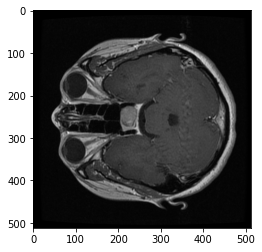

In [5]:
plt.imshow(img, "gray")
plt.show()

In [16]:
scale_percent = 40 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
resized.shape

(204, 204)

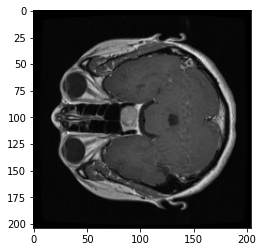

In [14]:
plt.imshow(resized, "gray")
plt.show()

In [6]:
# image processing

n_layers=1
wires=4
#rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, wires))

#device_names = ["qiskit.aer", "default.qubit", "qiskit.ibmq"]

dev4 = qml.device("default.qubit", wires=wires)
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # trainable parameter
    theta = np.pi / 2

    qml.RX(phi[i] * np.pi, wires=i)
    qml.RX(phi[i+1] * np.pi, wires=i+1)
    qml.RX(phi[i+2] * np.pi, wires=i+2)
    qml.RX(phi[i+3] * np.pi, wires=i+3)

    qml.CRZ(theta, wires=[i+1, i])
    qml.CRZ(theta, wires=[i+3, i+2])
    qml.CRX(theta, wires=[i+1, i])
    qml.CRX(theta, wires=[i+3, i+2])
    qml.CRZ(theta, wires=[i+2, i])
    qml.CRX(theta, wires=[i+2, i])
    #RandomLayers(rand_params, wires=list(range(4)))
    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=i)) # [qml.expval(qml.PauliZ(i)) for i in range(4)]

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 4
    out = np.zeros((H//step, W//step))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # average pooling 4x4 pixels
            px0 = X[i:i+step2, j:j+step2].mean()
            px1 = X[i:i+step2, j+step2:j+step].mean()
            px2 = X[i+step2:i+step, j:j+step2].mean()
            px3 = X[i+step2:i+step, j+step2:j+step].mean()

            phi = np.array([px0, px1, px2, px3])
            #phi = X[i:i+2, j:j+2].flatten()
            # apply
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


In [7]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))

 0: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╭RZ(1.57)──╭RX(1.57)──┤ ⟨Z⟩ 
 1: ──RX(3.14)──╰C─────────╰C─────────│──────────│──────────┤     
 2: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╰C─────────╰C─────────┤     
 3: ──RX(3.14)──╰C─────────╰C───────────────────────────────┤     



In [ ]:
# Images processing with a Quantum Convolutional Layer
folder = "../brain_tumor_dataset/all/" # .mat files folder

start = timer()
w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
all64 = sorted(listdir("../brain_tumor_dataset/processed/all/"))
for file in directs:
    #substart = timer()
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    image = np.array(f.get("cjdata/image"))
    if image.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    NorImages = image/255
    processed = QCONV1(NorImages, str(k)+" "+file, len(directs), step)
    #mask = np.array(f.get("cjdata/tumorMask"))/255
    #processedMask = QCONV1(mask, str(k)+" "+file, len(directs), step)
    #processed[i, j] = Quanv(NorImages[i, j], j+1, NorImages.shape[1])
    #np.savez_compressed("../brain_tumor_dataset/processed/all/"+file, image=processed, mask=processedMask, label=label)
    np.savez_compressed("../brain_tumor_dataset/processed/all/"+file, image=processed, label=label)
    #subend = timer()
    #print("\n"+str(timedelta(seconds=round(subend-substart))))
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

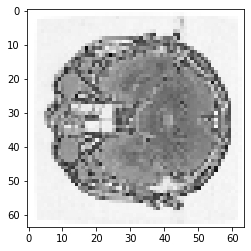

In [8]:
# after applying quantum filter
img = np.load("../brain_tumor_dataset/processed/all/1000.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()

In [32]:
# get processed data
folder = "../brain_tumor_dataset/processed/all/"
directs = sorted(listdir(folder))

images = []
masks = []
labels = []
i = 0
for file in directs:
    data = np.load(folder+file)
    images.append(data["image"])
    #masks.append(data["mask"])
    labels.append(data["label"])
    if i > 1000:
        break
    i+=1

npimages = np.asarray(images)
nplabels = np.asarray(labels)
#npmasks = np.asarray(masks)

In [34]:
npimages.shape, nplabels.shape#, npmasks.shape

((1002, 64, 64), (1002,))

In [35]:
# Make a train/test split using 30% test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((701, 64, 64), (301, 64, 64), (701,), (301,))

In [37]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(4, activation="softmax")
    ])
    model.compile(
        #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [38]:
q_model = Model()

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    verbose=2,
)

Epoch 1/10
44/44 - 1s - loss: 0.4495 - accuracy: 0.8659 - val_loss: 0.1691 - val_accuracy: 0.9369
Epoch 2/10
44/44 - 0s - loss: 0.1054 - accuracy: 0.9743 - val_loss: 0.0707 - val_accuracy: 0.9900
Epoch 3/10
44/44 - 0s - loss: 0.0446 - accuracy: 0.9971 - val_loss: 0.0720 - val_accuracy: 0.9801
Epoch 4/10
44/44 - 0s - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.0548 - val_accuracy: 0.9867
Epoch 5/10
44/44 - 0s - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9867
Epoch 6/10
44/44 - 0s - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9867
Epoch 7/10
44/44 - 0s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0473 - val_accuracy: 0.9900
Epoch 8/10
44/44 - 0s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0453 - val_accuracy: 0.9900
Epoch 9/10
44/44 - 0s - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0457 - val_accuracy: 0.9900
Epoch 10/10
44/44 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0444 - val_accuracy: 0.9900


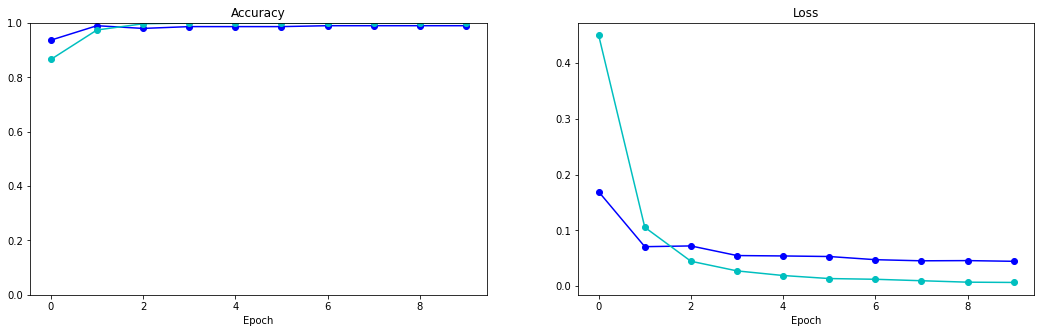

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob")
ax1.plot(q_history.history["accuracy"], "-oc")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(q_history.history["val_loss"], "-ob")
ax2.plot(q_history.history["loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [40]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [41]:
yhat.shape, y_test.shape

((301,), (301,))

In [42]:
from sklearn.metrics import classification_report
import itertools

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [44]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

         1.0       0.95      0.91      0.93        22
         2.0       1.00      0.94      0.97        17
         3.0       0.99      1.00      1.00       262

    accuracy                           0.99       301
   macro avg       0.98      0.95      0.97       301
weighted avg       0.99      0.99      0.99       301



Confusion matrix, without normalization


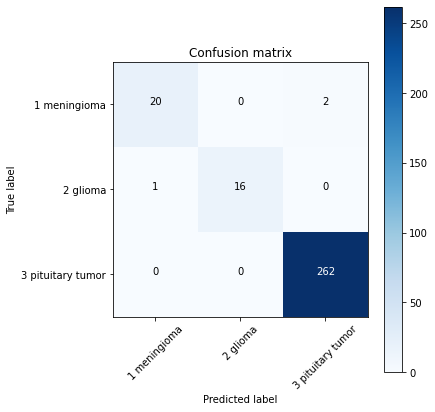

In [45]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

# Classical

In [17]:
# Images resizing
folder = "../brain_tumor_dataset/all/" # .mat files folder

w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
images = []
labels = []
#all64 = sorted(listdir("../brain_tumor_dataset/processed/all/"))
for file in directs:

    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    scale_percent = 40 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    images.append(np.expand_dims(np.array(resized), axis=2))
    labels.append(label)
    #NorImages = image/255
    
    if k > 1000:
        break
    k+=1
cimages = np.asarray(images)
clabels = np.asarray(labels)

In [18]:
# Make a train/test split using 30% test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cimages, clabels,
                                                    test_size=0.3,
                                                    random_state=42)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((701, 204, 204, 1), (301, 204, 204, 1), (701,), (301,))

In [22]:
model = K.applications.DenseNet121(
    include_top=True,
    weights=None, #"imagenet",
    input_tensor=None,
    input_shape=(204, 204, 1),
    pooling=None,
    classes=4,
)
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=10,
    verbose=1,
)

Epoch 1/10
44/44 [==============================] - 950s 21s/step - loss: 0.6744 - accuracy: 0.8315 - val_loss: 357.8324 - val_accuracy: 0.0565
Epoch 2/10
44/44 [==============================] - 897s 20s/step - loss: 0.1873 - accuracy: 0.9241 - val_loss: 22.8234 - val_accuracy: 0.3920
Epoch 3/10
44/44 [==============================] - 860s 20s/step - loss: 0.1676 - accuracy: 0.9232 - val_loss: 1.9355 - val_accuracy: 0.6213
Epoch 4/10
44/44 [==============================] - 848s 19s/step - loss: 0.1342 - accuracy: 0.9454 - val_loss: 0.8968 - val_accuracy: 0.7841
Epoch 5/10
44/44 [==============================] - 784s 18s/step - loss: 0.1649 - accuracy: 0.9413 - val_loss: 0.7084 - val_accuracy: 0.8671
Epoch 6/10
44/44 [==============================] - 808s 18s/step - loss: 0.1446 - accuracy: 0.9437 - val_loss: 0.3454 - val_accuracy: 0.8738
Epoch 7/10
44/44 [==============================] - 819s 19s/step - loss: 0.0938 - accuracy: 0.9707 - val_loss: 1.7229 - val_accuracy: 0.7774
Epo

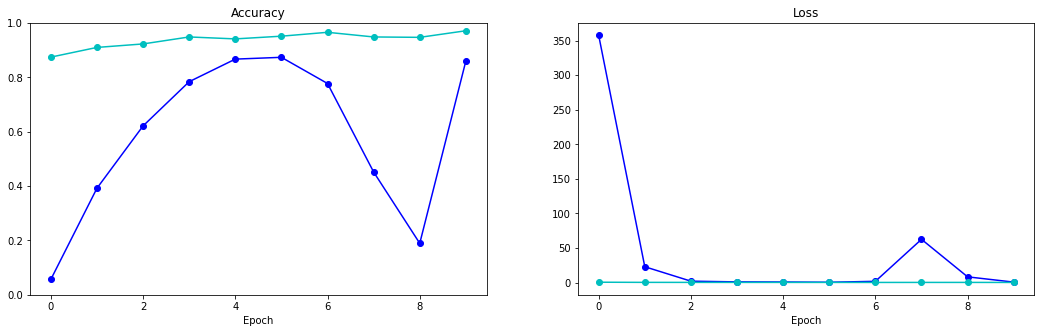

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob")
ax1.plot(history.history["accuracy"], "-oc")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(history.history["val_loss"], "-ob")
ax2.plot(history.history["loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [26]:
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [30]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.34      1.00      0.51        22
         2.0       1.00      0.53      0.69        17
         3.0       1.00      0.87      0.93       262

    accuracy                           0.86       301
   macro avg       0.78      0.80      0.71       301
weighted avg       0.95      0.86      0.89       301



Confusion matrix, without normalization


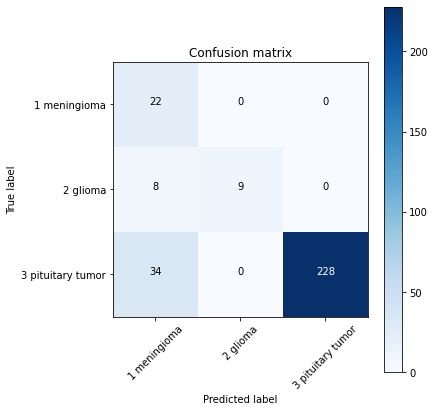

In [31]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')